In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.spatial import KDTree
from matplotlib import colors

In [2]:
# Custom code to load .list files
import stuff

In [3]:
stars, galaxies = stuff.parse_stuff_list('/home/aalvarez/Work/Data/sim09/sim09_r.list')

We have now the baseline. We train a KDTree with their coordinates, so we can cross-reference

In [4]:
star_coords = np.stack([stars.ra, stars.dec]).T
galaxy_coords = np.stack([galaxies.ra, galaxies.dec]).T
all_coords = np.append(star_coords, galaxy_coords, axis=0)

In [5]:
kdtree = KDTree(all_coords)

### Load the run with and without variable PSF

In [6]:
variable_catalog = Table.read('/home/aalvarez/Work/Projects/sextractorxx/tests/sim09_vpsf/sexpp.out.fits')
constant_catalog = Table.read('/home/aalvarez/Work/Projects/sextractorxx/tests/sim09/sexpp.out.fits')

### Plot an histogram of the distance to the closest match
The best model correspond to that one with more closer to some reference entry

In [7]:
def get_closest_distances(catalog):
    dist = []
    for e in catalog:
        dist.append(kdtree.query([e['smf_alpha'], e['smf_delta']], 1)[0])
    return dist

In [8]:
variable_closest = get_closest_distances(variable_catalog)
constant_closest = get_closest_distances(constant_catalog)

<IPython.core.display.Javascript object>


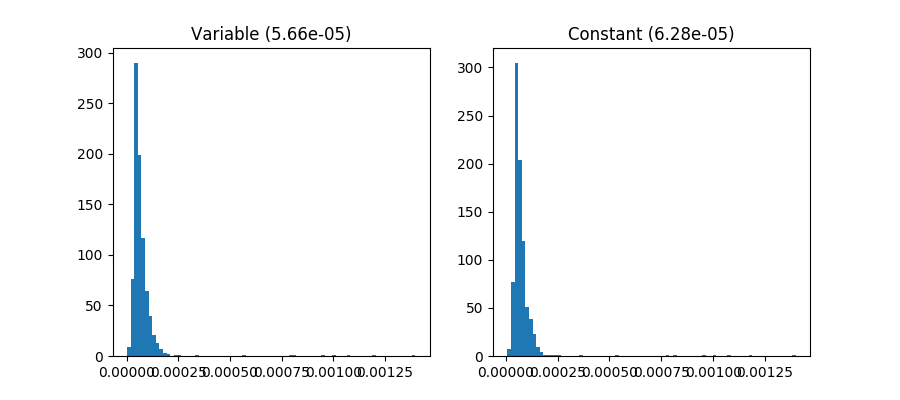

Text(0.5,1,'Constant (6.28e-05)')

In [9]:
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.hist(variable_closest, 80)
plt.title('Variable ({:.2e})'.format(np.median(variable_closest)))

plt.subplot(1, 2, 2)
plt.hist(constant_closest, 80)
plt.title('Constant ({:.2e})'.format(np.median(constant_closest)))

On a first sight, it would seem the variable PSF run get the position closest to the real one.

### Magnitudes

In [10]:
mag_zeropoint = 26 # This comes from sim09_r_sky.conf

In [33]:
constant_catalog['mag'] = mag_zeropoint - 2.5 * np.log10(constant_catalog['smf_total_flux']/300)
variable_catalog['mag'] = mag_zeropoint - 2.5 * np.log10(variable_catalog['smf_total_flux']/300)

In [34]:
constant_reverse_kdtree = KDTree(np.stack([constant_catalog['smf_alpha'], constant_catalog['smf_delta']]).T)
variable_reverse_kdtree = KDTree(np.stack([variable_catalog['smf_alpha'], variable_catalog['smf_delta']]).T)

In [35]:
def get_mag_diff(original, kdtree, catalog):
    err = []
    for o in original:
        closest_idx = kdtree.query([o.ra, o.dec], 1)[1]
        closest = catalog[closest_idx]
        err.append(closest['mag'] - o.mag)
    return err

In [36]:
constant_mag_diff_stars = get_mag_diff(stars, constant_reverse_kdtree, constant_catalog)
constant_mag_diff_galaxies = get_mag_diff(galaxies, constant_reverse_kdtree, constant_catalog)

In [37]:
variable_mag_diff_stars = get_mag_diff(stars, variable_reverse_kdtree, variable_catalog)
variable_mag_diff_galaxies = get_mag_diff(galaxies, variable_reverse_kdtree, variable_catalog)

<IPython.core.display.Javascript object>


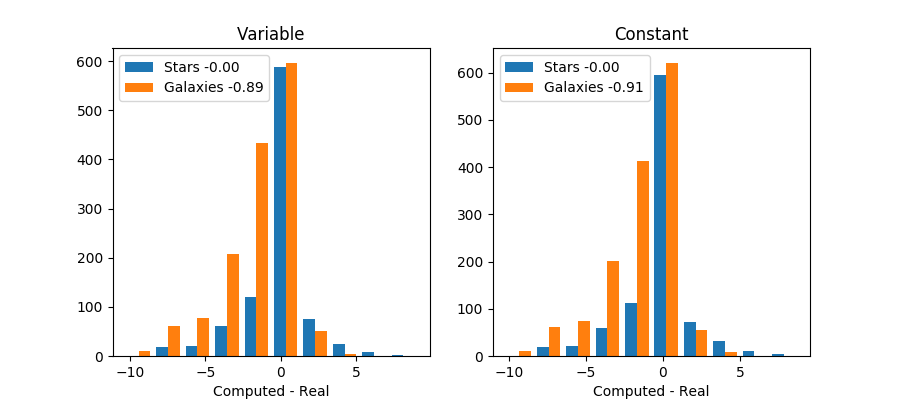

Text(0.5,1,'Constant')

In [38]:
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.hist(
    [variable_mag_diff_stars, variable_mag_diff_galaxies],
    label=[
        'Stars {:.2f}'.format(np.median(variable_mag_diff_stars)),
        'Galaxies {:.2f}'.format(np.median(variable_mag_diff_galaxies))
    ],
    histtype='bar', stacked=False
)
plt.legend()
plt.xlabel('Computed - Real')
plt.title('Variable')

plt.subplot(1, 2, 2)
plt.hist(
    [constant_mag_diff_stars, constant_mag_diff_galaxies],
    label=[
        'Stars {:.2f}'.format(np.median(constant_mag_diff_stars)),
        'Galaxies {:.2f}'.format(np.median(constant_mag_diff_galaxies))
    ],
    histtype='bar', stacked=False
)
plt.legend()
plt.xlabel('Computed - Real')
plt.title('Constant')

In [39]:
print(star_coords.shape)
print(np.array([variable_mag_diff_stars]).T.shape)

(924, 2)
(924, 1)


In [40]:
join = np.stack([star_coords[:,0], star_coords[:,1], variable_mag_diff_stars])

<IPython.core.display.Javascript object>


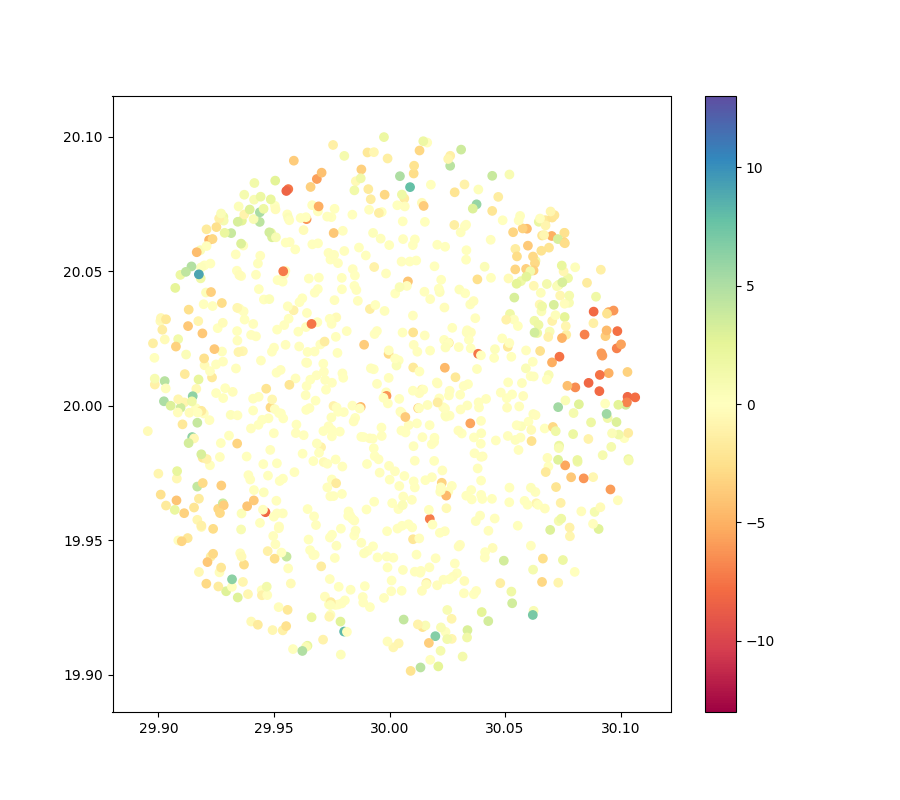

In [41]:
plt.figure(figsize=(9,8))
plt.scatter(
    star_coords[:,0], star_coords[:,1], c=variable_mag_diff_stars,
    cmap=plt.get_cmap('Spectral'),
    norm=colors.Normalize(vmin=-13, vmax=13)
)
plt.colorbar()

<IPython.core.display.Javascript object>


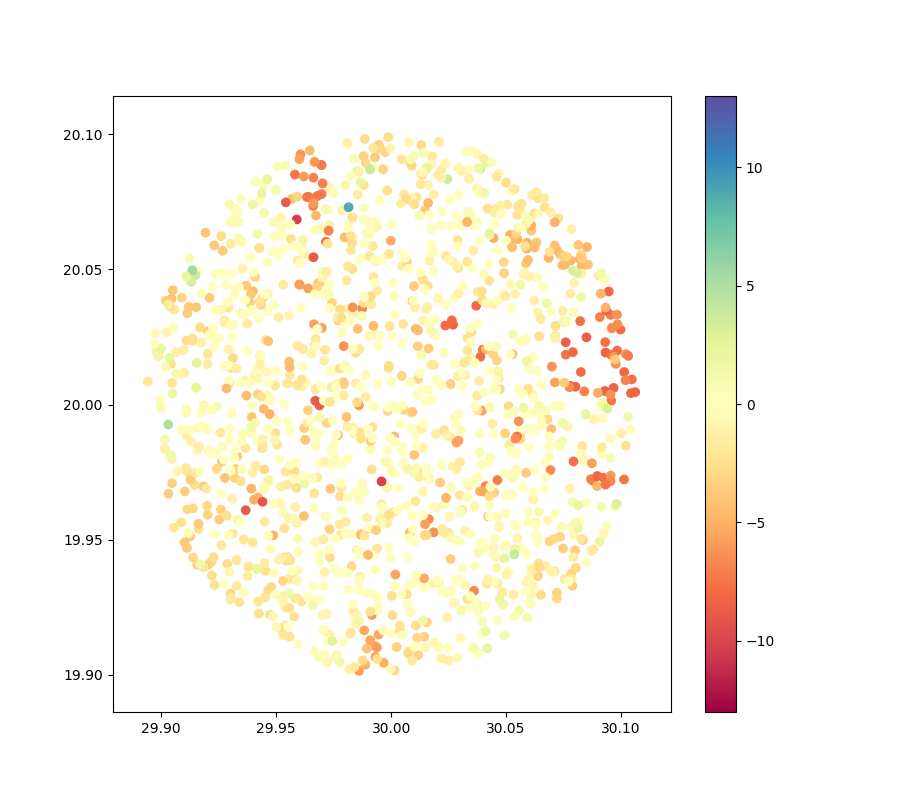

In [42]:
plt.figure(figsize=(9,8))
plt.scatter(
    galaxy_coords[:,0], galaxy_coords[:,1], c=variable_mag_diff_galaxies,
    cmap=plt.get_cmap('Spectral'),
    norm=colors.Normalize(vmin=-13, vmax=13)
)
plt.colorbar()

<IPython.core.display.Javascript object>


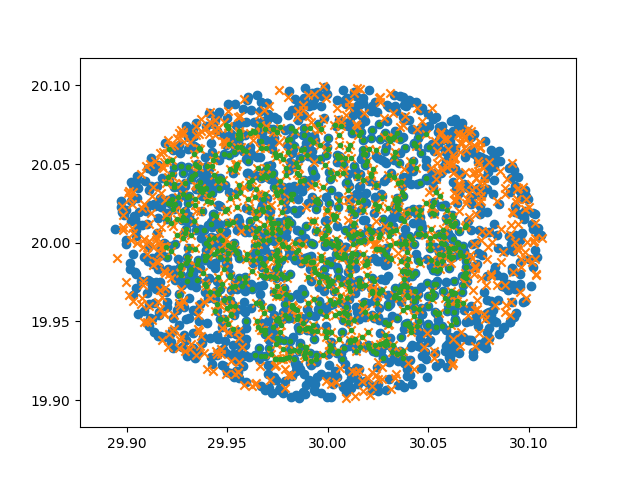

In [55]:
plt.figure()
plt.scatter(
    galaxy_coords[:,0], galaxy_coords[:,1],
    marker='o'
)
plt.scatter(
    star_coords[:,0], star_coords[:,1],
    marker='x'
)
plt.scatter(variable_catalog['smf_alpha'], variable_catalog['smf_delta'], marker='.')

In [48]:
print(np.average(constant_mag_diff_stars))
print(np.median(constant_mag_diff_stars))
print(np.std(constant_mag_diff_stars))

-0.29248863273085896
-0.004147169326820688
2.081456901140946


In [49]:
print(np.average(variable_mag_diff_stars))
print(np.median(variable_mag_diff_stars))
print(np.std(variable_mag_diff_stars))

-0.28676622544634045
-0.002517499985298599
2.0890770047432428
